<a href="https://colab.research.google.com/github/VardanDavtyan/ML-DL/blob/main/traffic_lights_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/drive/MyDrive

/content/drive/MyDrive


In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import tensorflow as tf
import albumentations
plt.rcParams["figure.figsize"] = (16, 9)
import json
from tensorflow.keras import layers, models

JSON data

In [ ]:
with open('lights_dataset/train_dataset/train.json', 'r') as file:
    data = json.load(file)

In [ ]:
coordinates_dict = {}

max_count = 200
count = 0

for annotation in data['annotations']:

    if count < max_count:
      filename = annotation['filename']
      xmin = annotation['bndbox']['xmin']
      ymin = annotation['bndbox']['ymin']
      xmax = annotation['bndbox']['xmax']
      ymax = annotation['bndbox']['ymax']

      if filename in coordinates_dict:
        coordinates_dict[filename].append([xmin, ymin, xmax, ymax, 1])
      else:
        coordinates_dict[filename] = [[xmin, ymin, xmax, ymax, 1]]
        count += 1


In [ ]:
imgs_boxes = []
img_files = []
for image_path in coordinates_dict:
  imgs_boxes.append(coordinates_dict[image_path])
  img_files.append(f'lights_dataset/train_dataset/train_images/{image_path[-9:]}')
imgs_boxes

[[[1026.5, 741.8, 1077.5, 910.9, 1],
  [1086.7, 863.1, 1131.3, 985.2, 1],
  [969.5, 874.6, 1035.6, 1005.1, 1]],
 [[1418.7, 1136.8, 1428.3, 1149.4, 1]],
 [[2574.3, 868.7, 2632.3, 887.1, 1], [2252.1, 899.6, 2300.8, 918.7, 1]],
 [[1053.2, 982.9, 1067.5, 1024.5, 1],
  [841.6, 1140.5, 851.9, 1159.5, 1],
  [792.3, 1065.6, 809.3, 1098.3, 1],
  [833.3, 1163.2, 843.6, 1184.8, 1],
  [1294.9, 1071.8, 1304.9, 1095, 1],
  [1311.8, 1072.4, 1333.3, 1089.6, 1],
  [1343, 1071.2, 1352.8, 1094.4, 1]],
 [[1056.1, 981.4, 1069.5, 1027.5, 1],
  [1296.4, 1071.6, 1303.8, 1095.4, 1],
  [1312.8, 1075.2, 1330.5, 1088.9, 1],
  [1342.9, 1070.1, 1351.3, 1094.4, 1],
  [1452.7, 1090.6, 1464.1, 1119.1, 1]],
 [[1056.1, 981.4, 1069.5, 1027.5, 1],
  [1296.4, 1071.6, 1303.8, 1095.4, 1],
  [1312.8, 1075.2, 1330.5, 1088.9, 1],
  [1342.9, 1070.1, 1351.3, 1094.4, 1],
  [1452.7, 1090.6, 1464.1, 1119.1, 1],
  [795.6, 1063.5, 807.1, 1104.4, 1]],
 [[2334.8, 611.5, 2448.8, 696.8, 1],
  [2253.8, 639.5, 2320.8, 744.3, 1],
  [1054.2, 

In [ ]:
max_objects = 27
for img_boxes in imgs_boxes:
  current_img_boxes_len = len(img_boxes)
  for i in range(max_objects - current_img_boxes_len):
   img_boxes.append([0, 0, 1, 1, 0])

In [ ]:
imgs_boxes = np.array(imgs_boxes).astype(int)

In [ ]:
imgs_boxes.shape

(200, 27, 5)

XML Data

In [ ]:
xmls = glob.glob("traffic_lights_data/train/*.xml")
xml_files = xmls
img_files = []
for xml_file in xml_files:
  img_files.append(xml_file.replace('.xml', '.jpg'))


In [ ]:
imgs_boxes = []
for xml_file in xml_files:
  tree = ET.parse(xml_file)
  root = tree.getroot()
  objects = root.findall('object')
  img_boxes = []
  for obj in objects:
    box = obj.find('bndbox')
    xmin = box.find('xmin').text
    ymin = box.find('ymin').text
    xmax = box.find('xmax').text
    ymax = box.find('ymax').text
    img_boxes.append(np.array([xmin, ymin, xmax, ymax], dtype=np.int32))
  imgs_boxes.append(img_boxes)
imgs_boxes

###################################################################

In [ ]:
imgs = []
for img_file in img_files:
  img = cv2.imread(img_file)
  img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
  imgs.append(img)

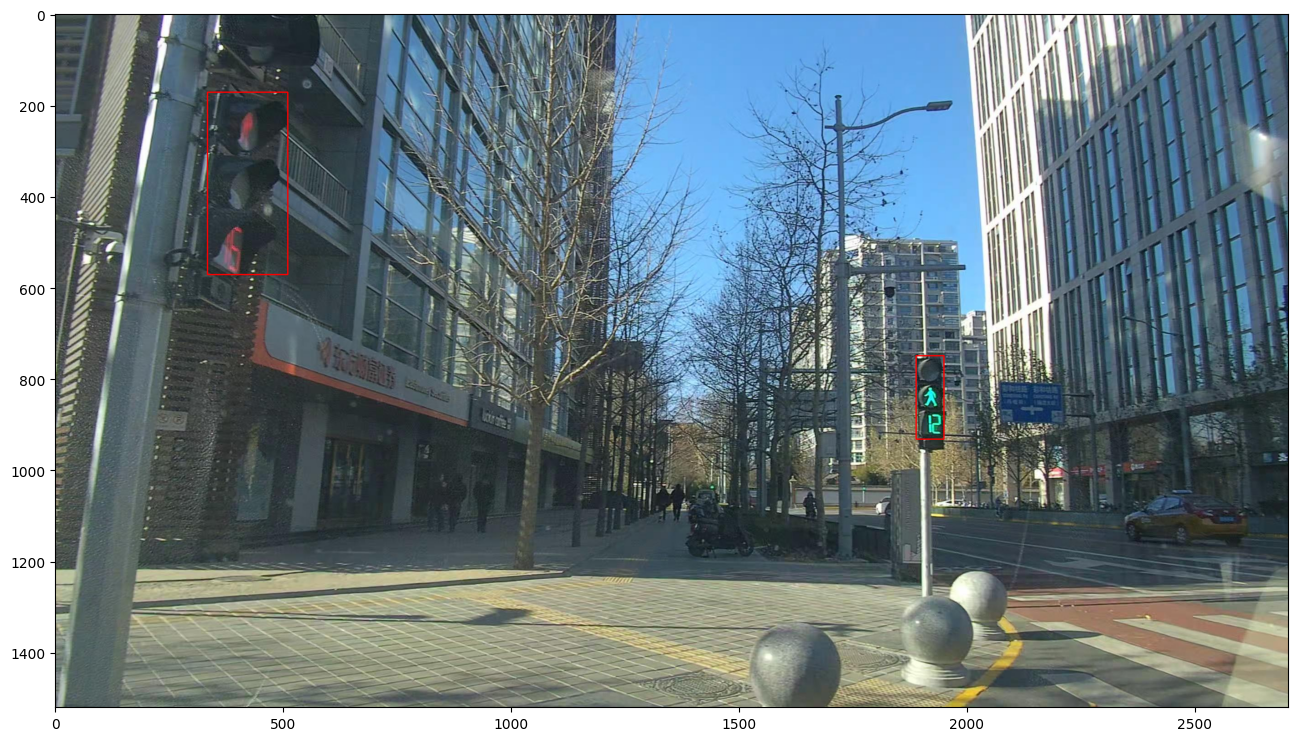

In [ ]:
index = 56
img_with_boxes = imgs[index].copy()
for box in imgs_boxes[index]:
  cv2.rectangle(img_with_boxes, box[:2], box[2:-1], (255, 0, 0), 2)
plt.imshow(img_with_boxes);

In [ ]:
def resize_image(img_arr, bboxes, max_size):
    """
    :param img_arr: original image as a numpy array
    :param bboxes: bboxes as numpy array where each row is 'x_min', 'y_min', 'x_max', 'y_max', "class_id"
    :param h: resized height dimension of image
    :param w: resized weight dimension of image
    :return: dictionary containing {image:transformed, bboxes:['x_min', 'y_min', 'x_max', 'y_max', "class_id"]}
    """
    # create resize transform pipeline
    result_image = np.zeros((max_size, max_size))
    transform = albumentations.Compose(
        [albumentations.LongestMaxSize(max_size=max_size, always_apply=True)],
        bbox_params=albumentations.BboxParams(format='pascal_voc'))

    transformed = transform(image=img_arr, bboxes=bboxes)
    transform_image, transform_bboxes = transformed['image'], transformed['bboxes']
    result_image[:transform_image.shape[0],:transform_image.shape[1]] = transform_image
    return result_image, transform_bboxes

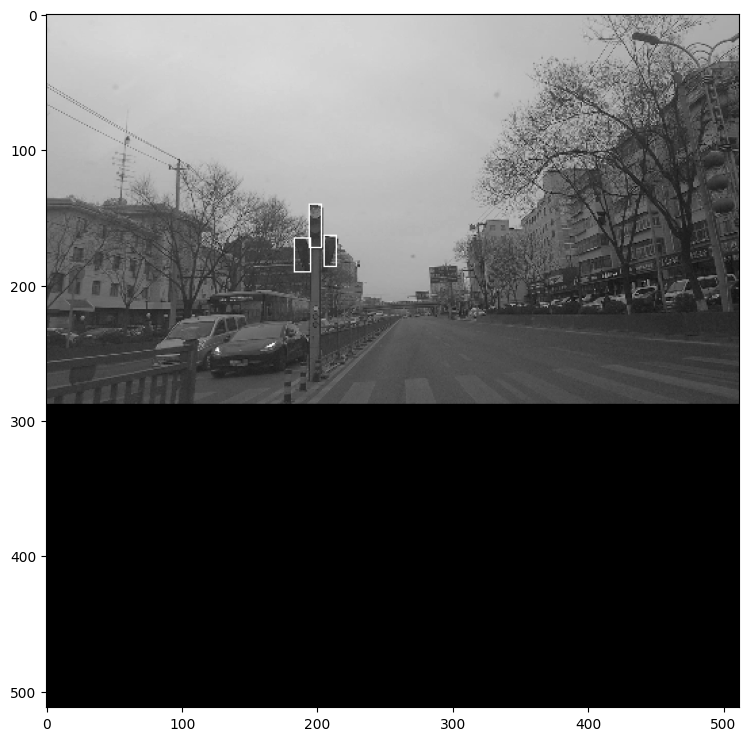

In [ ]:
i = 0
imgs_gray = []
imgs_resized = []
all_boxes_resized = []
for img in imgs:
  img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img_resized, boxes_resized = resize_image(img_gray, imgs_boxes[i], 512)

  imgs_gray.append(img_gray)
  imgs_resized.append(img_resized)
  all_boxes_resized.append(boxes_resized)

  # print(img_resized)
  if i == 0:
    img_with_boxes = img_resized.copy()
    for box in boxes_resized:
      box = np.array(box, dtype=np.int32)
      cv2.rectangle(img_with_boxes, box[:2], box[2:4], (255, 0, 0), 1)
    plt.imshow(img_with_boxes, cmap='gray')
    plt.show()

  i += 1

In [ ]:
all_boxes_resized = np.array(all_boxes_resized)

In [ ]:
class DenseWithDepth(tf.keras.layers.Layer):
    def __init__(self, units, depth, activation=None, name=None):
        self.units = units
        self.depth = depth
        self.activation = tf.keras.activations.get(activation)
        super().__init__(name=name)

    def build(self, input_shape):
        input_dim = input_shape[-1]
        self.kernels = []
        self.biases = []
        i = tf.constant(0)

        def append_kernel_bias(i):
            kernel = self.add_weight("kernel", (input_dim, self.units))
            bias = self.add_weight("bias", (self.units,))
            self.kernels.append(kernel)
            self.biases.append(bias)
            return (i + 1, )

        condition = lambda i: tf.less(i, self.depth)
        tf.while_loop(condition, append_kernel_bias, [i])

    def call(self, inputs):
        i = tf.constant(0)
        batch_size = tf.shape(inputs)[0]
        outputs = tf.TensorArray(tf.float32, size=self.depth)

        def append_out(i, outputs):
            out = tf.matmul(inputs, tf.gather(self.kernels, i) + tf.gather(self.biases, i))
            if self.activation is not None:
                out = self.activation(out)
            outputs = outputs.write(i, out)
            return i + 1, outputs

        condition = lambda i, _: tf.less(i, self.depth)
        _, outputs = tf.while_loop(condition, append_out, [i, outputs])
        outputs = outputs.stack()
        outputs = tf.transpose(outputs, perm=[1, 2, 0])  # Move the first dimension to the front
        return outputs

In [ ]:
input = tf.keras.layers.Input(shape=(*img_resized.shape, 1))
x = tf.keras.layers.Conv2D(64, 3, padding="same")(input)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, 5, padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256, 7, padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(128, 5, padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(512, activation="relu")(x)
output_boxes = DenseWithDepth(max_objects, 4, "relu", name="boxes_dense")(x)
# output_classes = DenseWithDepth(2, 20, "softmax", name="classes_dense")(x)
model = tf.keras.Model(input, [output_boxes])
model.summary()

In [ ]:
example_output = model(np.array([tf.expand_dims(imgs_resized[0], -1)]))
example_output

In [ ]:
def calculate_iou(y_true, y_pred):
    # Extract coordinates from true and predicted boxes
    y_true = y_true[..., :4]
    y_pred = y_pred[:, :y_true.shape[1]][..., :4]
    xmin_true, ymin_true, xmax_true, ymax_true = tf.unstack(y_true, axis=-1)
    xmin_pred, ymin_pred, xmax_pred, ymax_pred = tf.unstack(y_pred, axis=-1)

    # Calculate coordinates of intersection area
    x_left = tf.maximum(xmin_true, xmin_pred)
    y_top = tf.maximum(ymin_true, ymin_pred)
    x_right = tf.minimum(xmax_true, xmax_pred)
    y_bottom = tf.minimum(ymax_true, ymax_pred)

    # Calculate area of intersection
    intersection_area = tf.maximum(0.0, x_right - x_left) * tf.maximum(0.0, y_bottom - y_top)

    # Calculate area of true and predicted boxes
    area_true = (xmax_true - xmin_true) * (ymax_true - ymin_true)
    area_pred = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)

    # Calculate IoU
    iou = intersection_area / (area_true + area_pred - intersection_area)

    return -tf.reduce_mean(iou)

In [ ]:
model.compile(optimizer='adam',
              loss={'boxes_dense': calculate_iou},)

In [ ]:
model.fit(np.array([tf.expand_dims(imgs_resized, -1)])[0], np.array(all_boxes_resized, dtype=np.float32), batch_size=10, epochs=10)

In [ ]:
model.predict(np.array([np.array([tf.expand_dims(imgs_resized, -1)])[0][0]]))

In [ ]:
labels = all_boxes_resized[:, :, -1]
images_boxes = all_boxes_resized[:, :, :-1]
images_boxes

array([[[1.94272189e+02, 1.40400000e+02, 2.03928994e+02, 1.72421053e+02],
        [2.05633136e+02, 1.63515789e+02, 2.14153846e+02, 1.86631579e+02],
        [1.83479290e+02, 1.65600000e+02, 1.95976331e+02, 1.90421053e+02],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01]],

       [[2.68497041e+02, 2.15242105e+02, 2.70390533e+02, 2.17705263e+02],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        ...,
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01],
        [0.00000000e+00, 0.00000000e+00, 1.89349112e-01, 1.89473684e-01]],

       [[4.87384615e+02, 1.64463158e+02, 4.98366864e+02, 1.68063158e+02],
        

In [ ]:
num_classes = 2 #background or traffic light
labels_one_hot = tf.one_hot(tf.cast(labels, dtype=tf.int32), depth=num_classes)
labels_one_hot.shape

TensorShape([200, 27, 2])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
import keras.backend as K

class RoiPoolingConv(Layer):
    '''ROI pooling layer for 2D inputs.
    See Spatial Pyramid Pooling in Deep Convolutional Networks for Visual Recognition,
    K. He, X. Zhang, S. Ren, J. Sun
    # Arguments
        pool_size: int
            Size of pooling region to use. pool_size = 7 will result in a 7x7 region.
        num_rois: number of regions of interest to be used
    # Input shape
        list of two 4D tensors [X_img,X_roi] with shape:
        X_img:
        `(1, channels, rows, cols)` if dim_ordering='th'
        or 4D tensor with shape:
        `(1, rows, cols, channels)` if dim_ordering='tf'.
        X_roi:
        `(1,num_rois,4)` list of rois, with ordering (x,y,w,h)
    # Output shape
        3D tensor with shape:
        `(1, num_rois, channels, pool_size, pool_size)`
    '''
    def __init__(self, pool_size, num_rois, **kwargs):

        self.dim_ordering = K.common.image_dim_ordering()
        assert self.dim_ordering in {'tf', 'th'}, 'dim_ordering must be in {tf, th}'

        self.pool_size = pool_size
        self.num_rois = num_rois

        super(RoiPoolingConv, self).__init__(**kwargs)

    def build(self, input_shape):
        if self.dim_ordering == 'th':
            self.nb_channels = input_shape[0][1]
        elif self.dim_ordering == 'tf':
            self.nb_channels = input_shape[0][3]

    def compute_output_shape(self, input_shape):
        if self.dim_ordering == 'th':
            return None, self.num_rois, self.nb_channels, self.pool_size, self.pool_size
        else:
            return None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels

    def call(self, x, mask=None):

        assert(len(x) == 2)

        img = x[0]
        rois = x[1]

        input_shape = K.shape(img)

        outputs = []

        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            row_length = w / float(self.pool_size)
            col_length = h / float(self.pool_size)

            num_pool_regions = self.pool_size

            #NOTE: the RoiPooling implementation differs between theano and tensorflow due to the lack of a resize op
            # in theano. The theano implementation is much less efficient and leads to long compile times

            if self.dim_ordering == 'th':
                for jy in range(num_pool_regions):
                    for ix in range(num_pool_regions):
                        x1 = x + ix * row_length
                        x2 = x1 + row_length
                        y1 = y + jy * col_length
                        y2 = y1 + col_length

                        x1 = K.cast(x1, 'int32')
                        x2 = K.cast(x2, 'int32')
                        y1 = K.cast(y1, 'int32')
                        y2 = K.cast(y2, 'int32')

                        x2 = x1 + K.maximum(1,x2-x1)
                        y2 = y1 + K.maximum(1,y2-y1)

                        new_shape = [input_shape[0], input_shape[1],
                                     y2 - y1, x2 - x1]

                        x_crop = img[:, :, y1:y2, x1:x2]
                        xm = K.reshape(x_crop, new_shape)
                        pooled_val = K.max(xm, axis=(2, 3))
                        outputs.append(pooled_val)

            elif self.dim_ordering == 'tf':
                x = K.cast(x, 'int32')
                y = K.cast(y, 'int32')
                w = K.cast(w, 'int32')
                h = K.cast(h, 'int32')

                rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
                outputs.append(rs)

        final_output = K.concatenate(outputs, axis=0)
        final_output = K.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        if self.dim_ordering == 'th':
            final_output = K.permute_dimensions(final_output, (0, 1, 4, 2, 3))
        else:
            final_output = K.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output


    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [ ]:
#FastRcnn like model
num_anchors = 9

input = tf.keras.layers.Input(shape=(*img_resized.shape, 1))

x = tf.keras.layers.Conv2D(64, 3, padding="same")(input)
x = tf.keras.layers.Conv2D(64, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(128, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)


x = tf.keras.layers.Conv2D(256, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(256, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(256, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

x = tf.keras.layers.Conv2D(512, 3, padding="same")(x)

rpn_reg = layers.Conv2D(num_anchors * 4, (1, 1), activation='linear', name='rpn_reg')(x)
rpn_class = layers.Conv2D(num_anchors * 2, (1, 1), activation='softmax', name='rpn_class')(x)


x1 = tf.keras.layers.GlobalAveragePooling2D()(rpn_reg)
x2 = tf.keras.layers.GlobalAveragePooling2D()(rpn_class)
x = tf.keras.layers.Concatenate()([x1, x2])

fc1 = layers.Dense(4096, activation='relu')(x)
fc2 = layers.Dense(4096, activation='relu')(fc1)


output_boxes = DenseWithDepth(max_objects, 4, "relu", name="boxes_dense")(fc2)
output_classes = DenseWithDepth(max_objects, 2, "softmax", name="classes_dense")(fc2)

model = tf.keras.Model(input, [output_classes, output_boxes])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 512, 512, 1)]        0         []                            
                                                                                                  
 conv2d_28 (Conv2D)          (None, 512, 512, 64)         640       ['input_3[0][0]']             
                                                                                                  
 conv2d_29 (Conv2D)          (None, 512, 512, 64)         36928     ['conv2d_28[0][0]']           
                                                                                                  
 max_pooling2d_10 (MaxPooli  (None, 256, 256, 64)         0         ['conv2d_29[0][0]']           
 ng2D)                                                                                        

In [ ]:
model.compile(optimizer='adam', loss={'boxes_dense': calculate_iou, 'classes_dense': 'categorical_crossentropy',
                                   })

dummy_labels = {
                'classes_dense': labels_one_hot,
                'boxes_dense': images_boxes}
model.fit(np.array([tf.expand_dims(imgs_resized, -1)])[0], dummy_labels, batch_size=5, epochs=1)

 1/40 [..............................] - ETA: 39:53 - loss: nan - classes_dense_loss: nan - boxes_dense_loss: -1.8439e-06

KeyboardInterrupt: ignored